In [68]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model, rvirModel
from haloclustering.data import get_combined_dataset
import haloclustering.evalulate_model as evaluate
from haloclustering import data as datamodule
from haloclustering import r_cgm
from astropy.cosmology import Planck15 as cosmo
import casbah.gal_properties as caprop
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load in the data and posterior samples 

In [65]:
onehalopklfile = "/Users/mwilde/python/haloclustering/haloclustering/notebooks/base_model/model_1beta_mass_dependence_sampler.pkl"
twohalopklfile = "/Users/mwilde/python/haloclustering/haloclustering/notebooks/two-halo-only/model_2h_only_full_range_sampler.pkl"
rvirhalopklfile = '/Users/mwilde/python/haloclustering/haloclustering/notebooks/rvir_as_r0/model_rvir_as_r0_sampler.pkl'
#cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
#casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
# data = get_combined_dataset(cgmsqfile, casdir)
sampler = datamodule.get_sampler_pickle_file(onehalopklfile)
samplerRvir = datamodule.get_sampler_pickle_file(rvirhalopklfile)
sampler_2h_only = datamodule.get_sampler_pickle_file(twohalopklfile)
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
flat_samplesRvir = samplerRvir.get_chain(discard=1000, thin=50, flat=True)
flat_samples_2h_only = sampler_2h_only.get_chain(discard=1000, thin=50, flat=True)

In [66]:
def limits(sample):
    
    hi = np.nanquantile(sample, 0.86)
    med = np.nanquantile(sample, 0.5)
    low = np.nanquantile(sample, 0.14)
    
    return med, hi, low

In [69]:
data = datamodule.make_grid_data(9.5, 0.1)
# instantiate the model with fake data at a single mass and redshift
model = Model(data)
modelRvir = rvirModel(data)
# compute the distribution of R_21 at that mass and redshift
r21_sample = r_cgm.compute_Rcrossing(model, flat_samples, thin=500)

In [67]:
def r21_grid(Model, flat_samples):
    npts_mass = 50
    npts_z = 1

    mass_space = np.linspace(7, 11.5, npts_mass)
    #redshift_space = np.linspace(0.1, 0.5, npts_z)
    redshift_space = [0.3]

    r21_realization_list = []
    r21_med_list = []
    r21_hi_list = []
    r21_low_list = []


    for redshift_i in redshift_space:
        r21_realization_list_single_redshift = []
        r21_med_list_at_single_redshift = []
        r21_hi_list_at_single_redshift = []
        r21_low_list_at_single_redshift = []
        for mass_i in mass_space:
            data_m_z = datamodule.make_grid_data(mass_i, redshift_i)
            rvirModelgrid = Model(data_m_z)
            r21_sample = r_cgm.compute_Rcrossing(rvirModelgrid, flat_samples, thin=1, log=False, only_crossing=True)        
            r21_med, r21_hi, r21_low = limits(r21_sample)
                
            r21_realization_list_single_redshift.append(r21_sample)
            r21_med_list_at_single_redshift.append(r21_med)
            r21_hi_list_at_single_redshift.append(r21_hi)
            r21_low_list_at_single_redshift.append(r21_low)
        r21_realization_list.append(r21_realization_list_single_redshift)    
        r21_med_list.append(r21_med_list_at_single_redshift)
        r21_hi_list.append(r21_hi_list_at_single_redshift)
        r21_low_list.append(r21_low_list_at_single_redshift)
    return r21_med_list, r21_hi_list, r21_low_list

### compute R_21 at a grid in mass and redshift

In [23]:
npts_mass = 50
npts_z = 1

mass_space = np.linspace(7, 11.5, npts_mass)
#redshift_space = np.linspace(0.1, 0.5, npts_z)
redshift_space = [0.3]

r21_realization_list = []
r21_med_list = []
r21_hi_list = []
r21_low_list = []


for redshift_i in redshift_space:
    r21_realization_list_single_redshift = []
    r21_med_list_at_single_redshift = []
    r21_hi_list_at_single_redshift = []
    r21_low_list_at_single_redshift = []
    for mass_i in mass_space:
        data_m_z = datamodule.make_grid_data(mass_i, redshift_i)
        rvirModelgrid = Model(data_m_z)
        r21_sample = r_cgm.compute_Rcrossing(rvirModelgrid, flat_samples, thin=1, log=False, only_crossing=True)        
        r21_med, r21_hi, r21_low = limits(r21_sample)
             
        r21_realization_list_single_redshift.append(r21_sample)
        r21_med_list_at_single_redshift.append(r21_med)
        r21_hi_list_at_single_redshift.append(r21_hi)
        r21_low_list_at_single_redshift.append(r21_low)
    r21_realization_list.append(r21_realization_list_single_redshift)    
    r21_med_list.append(r21_med_list_at_single_redshift)
    r21_hi_list.append(r21_hi_list_at_single_redshift)
    r21_low_list.append(r21_low_list_at_single_redshift)

In [70]:
r21_med_listRvir, r21_hi_listRvir, r21_low_listRvir = r21_grid(rvirModel, flat_samplesRvir)

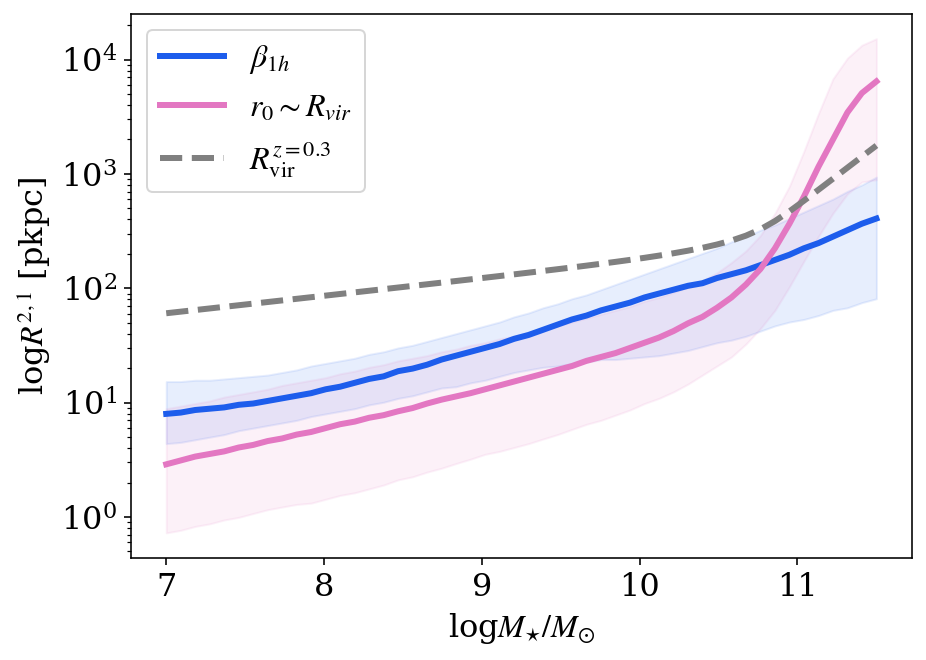

In [73]:
logmhalo_z0p3 = [
        caprop.calchalomass(mstar, 0.3)
        for mstar in mass_space]

rvir_z0p3 = np.array([caprop.calcrvir(mh, 0.3) for mh in logmhalo_z0p3])
color=["xkcd:azul", "tab:pink"]
plt.figure(figsize=(7,5))
for idx, z in enumerate(redshift_space):
    plt.plot(mass_space, r21_med_list[idx], label=r'$\beta_{1h}$', lw=3, color=color[idx])
    plt.fill_between(mass_space, r21_low_list[idx], r21_hi_list[idx], color="xkcd:azul",
                     alpha=0.1)
    plt.plot(mass_space, r21_med_listRvir[idx], label=r'$r_0 \sim R_{vir}$', lw=3, color="tab:pink")
    plt.fill_between(mass_space, r21_low_listRvir[idx], r21_hi_listRvir[idx], color="tab:pink",
                     alpha=0.1)
    
plt.plot(mass_space, rvir_z0p3, ls='--', lw=3, 
         label=r'$R_{\rm vir }^{z=0.3}$', c='grey')

plt.yscale('log')
plt.xlabel(r'log$M_{\star}/M_{\odot}$');
plt.ylabel(r'log$R^{2,1}$ [pkpc]')
# plt.legend(bbox_to_anchor=(1, 0.99));
plt.legend()
plt.savefig('r21_base_model.png')

# Deconstruct R21 crossing to plot schemtatic and compute fraction of non-crossingings as a funciton of mass

In [29]:
flat_samples.shape

(48000, 8)

In [74]:
model.set_params(flat_samples.T)

In [75]:
fc_1h = model.phit_1halo()
fc_2h = model.phit_2halo()

In [76]:
fc_1h.shape, fc_2h.shape, (fc_2h - fc_1h).shape

((960, 1000), (960, 1000), (960, 1000))

In [85]:
np.diff(np.sign(fc_2h - fc_1h), axis=0).shape

(959, 1000)

In [59]:
r_lin = model.rho_com
cross_cut = (r_lin > 1e-4) & (r_lin < 1e0)

In [52]:
crossingpoint = np.where(np.diff(np.sign(fc_2h - fc_1h)) == 2)[0]
crossingpoint.shape

(480,)

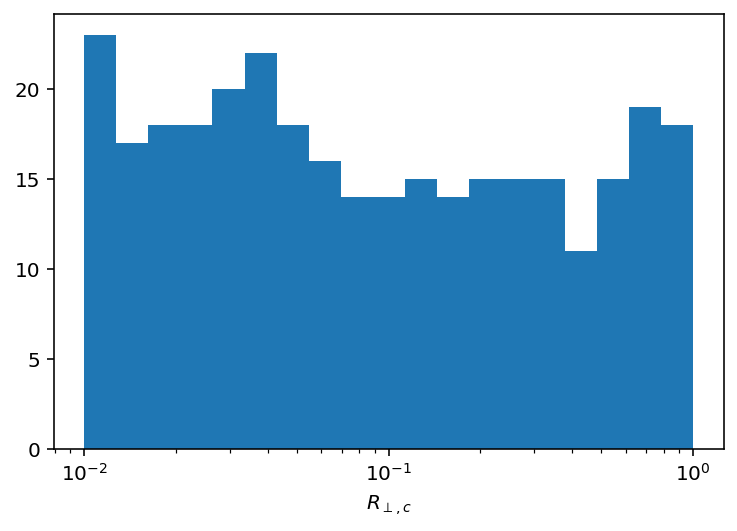

In [65]:
plt.hist(r_lin[crossingpoint], bins=np.geomspace(1e-2,1e0, 20));
plt.xlabel(r'$R_{\perp,c}$');
plt.xscale('log')

In [77]:
data = datamodule.make_grid_data(9.5, 0.1)
# instantiate the model with fake data at a single mass and redshift
model = Model(data)
# compute the distribution of R_21 at that mass and redshift
r21_sample = r_cgm.compute_Rcrossing(model, flat_samples, thin=5)

(array([105.,   8.,   5.,  10.,  11.,  20.,  19.,  11.,   1.,   2.]),
 array([1.0016553, 1.1235852, 1.2455152, 1.3674451, 1.4893751, 1.611305 ,
        1.7332349, 1.8551649, 1.9770948, 2.0990248, 2.2209547],
       dtype=float32),
 <BarContainer object of 10 artists>)

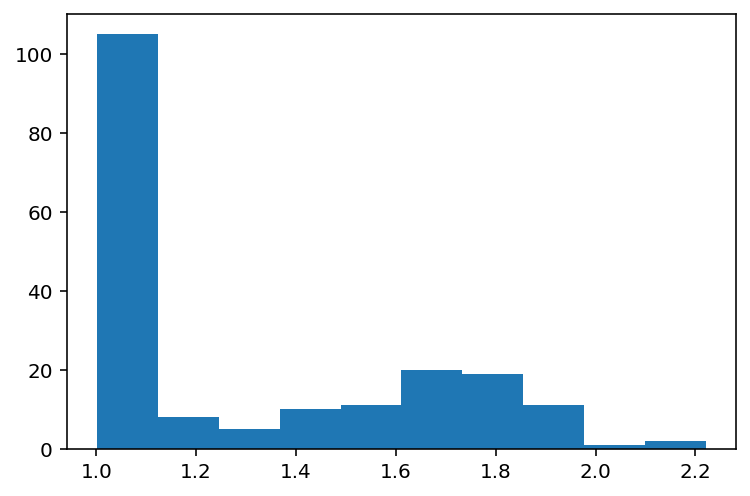

In [78]:
plt.hist(r21_sample)

In [55]:
np.all(np.sign(np.sum(fc_2h - fc_1h, axis=1))) == 1

True

In [56]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)

def plot_fc_1h_2h(ax, flat_samples, mass=9.5, redshift=0.1):
    data = datamodule.make_grid_data(mass, redshift)
    # instantiate the model with fake data at a single mass and redshift
    model = Model(data)
    model.set_params(flat_samples.T)
    fc_1h = model.phit_1halo()
    fc_2h = model.phit_2halo()

    # r_lin = data[1]
    r_lin = model.rho_com
    ax.plot(r_lin, fc_2h.T, c='grey', alpha=0.01)
    ax.plot(r_lin, fc_1h.T, c='xkcd:azul', alpha=0.01)
    ax.set_xlim(1e-4, 2e1)
    ax.set_xscale('log')
    # plt.yscale('log')
    # ax.set_xlabel(r'$R_{\perp,c}$')
    ax.set_ylabel(r'$f_c$')
    masslabel = r"log $M_{{\star}}$ = {0}".format(mass)
    ax.text(0.7, 0.75, masslabel, transform=ax.transAxes)
    return ax
    # plt.grid(True)

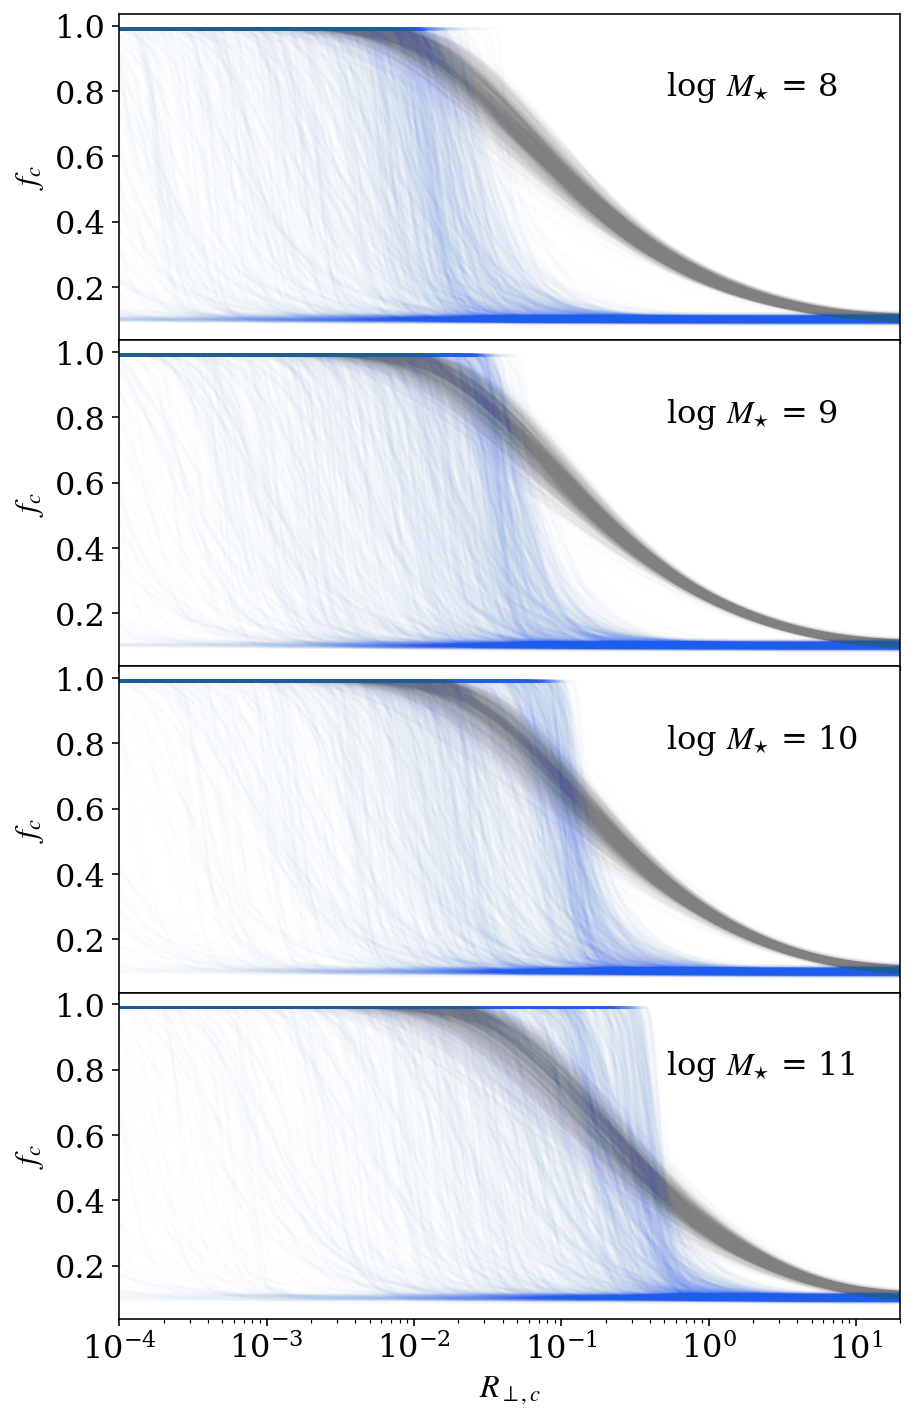

In [59]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,12), sharex=True)

mass_list = [8, 9, 10, 11]
for idx in range(len(mass_list)):
    a = plot_fc_1h_2h(axes[idx], flat_samples=flat_samples, mass=mass_list[idx])
a.set_xlabel(r'$R_{\perp,c}$')
fig.subplots_adjust(hspace=0.)
fig.savefig("crossingpoint_basemodel.png")

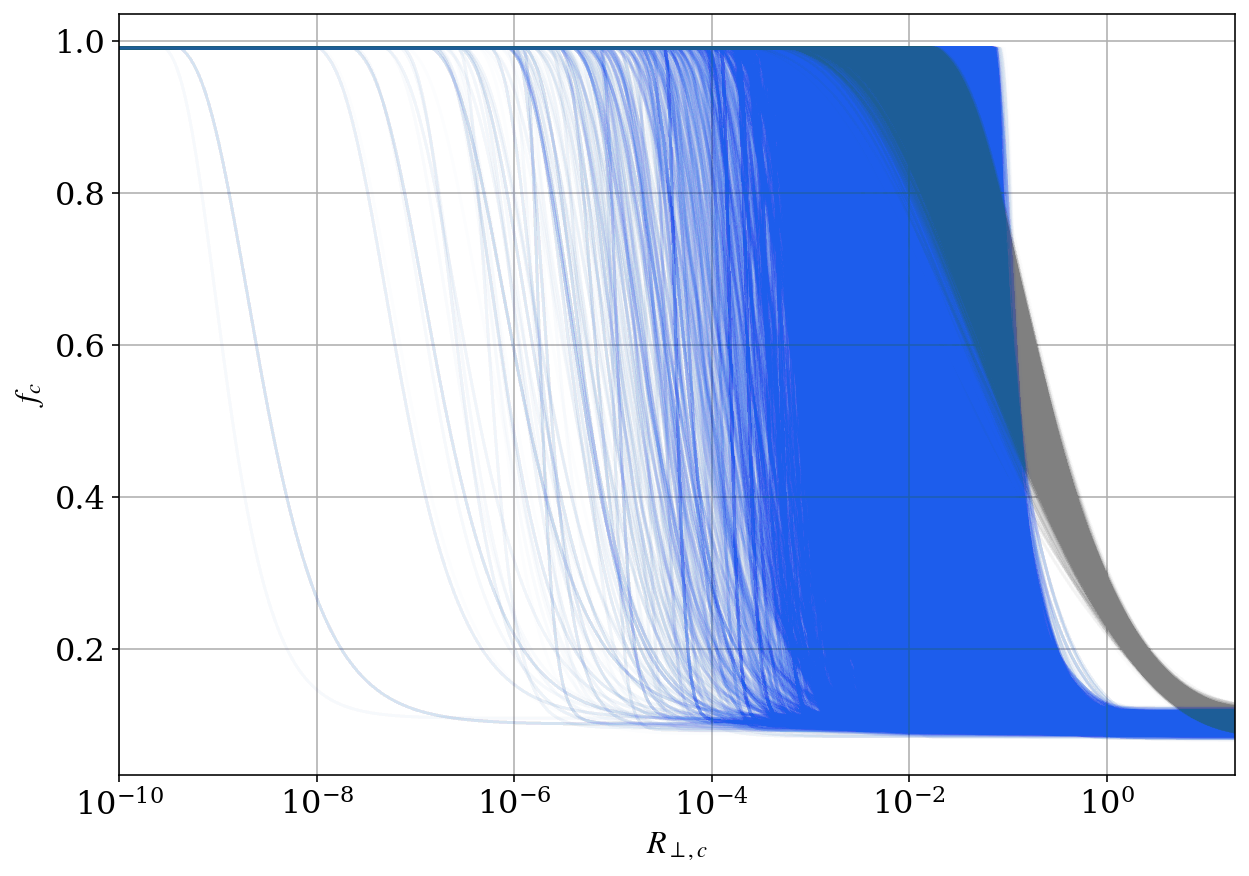

In [35]:
# r_lin = data[1]
r_lin = model.rho_com
plt.figure(figsize=(10,7))
plt.plot(r_lin, fc_2h.T, c='grey', alpha=0.01)
plt.plot(r_lin, fc_1h.T, c='xkcd:azul', alpha=0.01)
plt.xlim(1e-10, 2e1)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$R_{\perp,c}$')
plt.ylabel(r'$f_c$')
plt.grid(True)

In [ ]:
r_cross = 